# Multidimensional Pattern identification with SAX
## Cross building/attribute slice

This script performs pattern identification over the {site, attribute} cuboid, which allows exploration of cross-building/attributes combined analysis within a fixed time slice of interested.

The data is first normalized then transformed using SAX over normalized daily sequences. Motifs are identified across buildings, and a final clustering phase is executed over the reduced counts of sequences. 

Results are presented visually allowing interpretable analytics.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Plotting modules
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
plt.rcdefaults()
# Plotly
import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.io as pio
# Importing utility script
import utils as ut

# Version
version = "v1.0"

# Path definition
path_data = "..\\data\\cube\\"
path_fig_out = "..\\figures\\cross_blgattrib_slice\\"

## Read

In [2]:
# Read Cuboid
timestamp = "2016-06-07"
df = pd.read_csv(path_data + "cuboid_C_2016-06-07.csv", header=[0,1])
# Drop first row - full of NaNs from multi-column csv format
df.drop(0, axis=0, inplace=True)

# Set & format index
df.set_index(df.columns.values[0], inplace=True)
df.index.rename("timestamp", inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

# Drop columns full of NaNs
df.dropna(axis=1, how='all', inplace=True)
df.head()

electricity                         \
                    Bear_assembly_Angel Bear_assembly_Beatrice   
timestamp                                                        
2016-06-07 00:00:00              237.75                57.3125   
2016-06-07 01:00:00              256.75                49.0625   
2016-06-07 02:00:00              278.25                40.1250   
2016-06-07 03:00:00              306.50                36.9375   
2016-06-07 04:00:00              394.50                37.0625   

                                                             \
                    Bear_assembly_Diana Bear_assembly_Genia   
timestamp                                                     
2016-06-07 00:00:00            0.586914             203.875   
2016-06-07 01:00:00            0.626465             196.500   
2016-06-07 02:00:00            0.618164             193.875   
2016-06-07 03:00:00            0.595703             193.875   
2016-06-07 04:00:00            0.609375             195.125   

                                                                              \
                    Bear_assembly_Jose Bear_assembly_Roxy Bear_assembly_Ruby   
timestamp                                                                      
2016-06-07 00:00:00            201.625            10.6875            65.1875   
2016-06-07 01:00:00            196.875            10.6875            61.6875   
2016-06-07 02:00:00            188.875            10.8125            57.2500   
2016-06-07 03:00:00            185.750            10.8125            56.5625   
2016-06-07 04:00:00            196.875            10.8125            56.1250   

                                                                  \
                    Bear_education_Alfredo Bear_education_Alvaro   
timestamp                                                          
2016-06-07 00:00:00               0.109985                406.00   
2016-06-07 01:00:00               0.114380                398.50   
2016-06-07 02:00:00               0.112488                391.25   
2016-06-07 03:00:00               0.111267                385.50   
2016-06-07 04:00:00               0.111877                382.50   

                                           ...      seaLvlPressure  \
                    Bear_education_Arnold  ... Swan_unknown_Jerold   
timestamp                                  ...                       
2016-06-07 00:00:00              0.469727  ...              1011.5   
2016-06-07 01:00:00              0.457031  ...              1012.0   
2016-06-07 02:00:00              0.472656  ...              1011.5   
2016-06-07 03:00:00              0.464600  ...              1012.0   
2016-06-07 04:00:00              0.448975  ...              1012.0   

                                                             \
                    Swan_unknown_Noelia Swan_unknown_Raquel   
timestamp                                                     
2016-06-07 00:00:00              1011.5              1011.5   
2016-06-07 01:00:00              1012.0              1012.0   
2016-06-07 02:00:00              1011.5              1011.5   
2016-06-07 03:00:00              1012.0              1012.0   
2016-06-07 04:00:00              1012.0              1012.0   

                                                                             \
                    Swan_unknown_Reyna Swan_unknown_Rocco Swan_unknown_Rudy   
timestamp                                                                     
2016-06-07 00:00:00             1011.5             1011.5            1011.5   
2016-06-07 01:00:00             1012.0             1012.0            1012.0   
2016-06-07 02:00:00             1011.5             1011.5            1011.5   
2016-06-07 03:00:00             1012.0             1012.0            1012.0   
2016-06-07 04:00:00             1012.0             1012.0            1012.0   

                                                                              \
                    Swan_unkn

# Pre-Mining
## Cross building/attribute motifs identification

In [3]:
# Timerange definition
start_date = df.index.values[0]
end_date = df.index.values[-1]

### OLAP
# Daily averaging
df_d = df.copy().resample('D').mean()
df_d = df_d.transpose().reset_index()
df_d.columns = ["meter", "building_id", "value"]
df_olap = df_d.pivot(index="meter", columns="building_id", values="value")
df_olap = df_olap.dropna(axis=1, how='all').transpose()

# Normalize per column (attribute)
scaler_function = MinMaxScaler() #StandardScaler()
df_olap_normalized = ut.scale_df_columns_NanRobust(df_olap, target_columns=df_olap.columns, scaler=scaler_function)
df_olap_normalized.head()

meter,airTemperature,chilledwater,electricity,hotwater,seaLvlPressure
building_id,,,,,
Bear_assembly_Angel,NaN,NaN,0.139776,NaN,NaN
Bear_assembly_Beatrice,NaN,NaN,0.013537,NaN,NaN
Bear_assembly_Diana,NaN,NaN,0.000224,NaN,NaN
Bear_assembly_Genia,NaN,NaN,0.065110,NaN,NaN
Bear_assembly_Jose,NaN,NaN,0.073948,NaN,NaN


In [4]:
### OLAM
# Data manipulation to get daily SAX
df1 = ut.multi2singlecol_1stCol(df)

# SAX Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

# Normalize per column (here attribute) robust to Nans
columns_considered = ["electricity", "hotwater", "chilledwater","airTemperature", "seaLvlPressure"]
df_normalized = ut.scale_df_columns_NanRobust(df1, target_columns=columns_considered, scaler=scaler_function)

# Now loop over unmerged column to perform SAX
sax_dict, counts, sax_data = dict(), dict(), dict()
dfs = []
for blg in df_normalized['building_id'].unique():
    sax_dict[blg], counts[blg], sax_data[blg] = ut.SAX_mining(df_normalized[columns_considered][df_normalized['building_id'] == blg],
                                                           W=day_number_of_pieces, A=alphabet_size)
    # Append the results to a list
    dfs.append(pd.DataFrame(sax_dict[blg].items(), columns=['Meter', blg]).set_index('Meter'))
# Concatenate the list to a common dataframe
df_sax_dict = pd.concat(dfs, axis=1)

# Post-processing
for col in df_sax_dict.columns:
    df_sax_dict[col] = list(ut.flatten_list([[subitem for subitem in ut.checkIfExists(item)] for item in df_sax_dict[col].values]))

### Grouping identical buildings from multi-attribute sequences together

In [5]:
## Visualize cross-building/attribute SAX count heatmap

# Pivoting & reindexing the dataframe for plotting
df_text = df_sax_dict.transpose().reindex(columns=columns_considered)
df_olap_normalized = df_olap_normalized.reindex(columns=columns_considered)

#Groupby Object to identify SAX sequence duplicates in cuboid slice
df_text_groupby = df_text.groupby(df_text.columns.values.tolist())
df_text_group = df_text_groupby.size().reset_index()

# Identifying building index list from groupby object with get_group()
one_blg, all_blgs = [], []
for name, group in df_text_groupby:
    one_blg.append(df_text_groupby.get_group(name).index[0])
    all_blgs.append(df_text_groupby.get_group(name).index.values)
# Adding building_id as a new column
df_text_group['building_id'] = one_blg
df_text_group['all_buildings'] = all_blgs
# Set New Index
df_text_group.set_index('building_id', drop=True, inplace=True)
# Dataframe of groupby counts without building index
df_text_group = df_text_group.rename(columns = {0:'count'})
df_text_group.sort_values(by=['count'], ascending=True, inplace=True)

## Filtering out building groups with fewer than 5 similar sequence counts
df_text_group_filter = df_text_group[df_text_group['count'] > 5]

df_text_group_filter.head()

,electricity,hotwater,chilledwater,airTemperature,seaLvlPressure,count,all_buildings
building_id,,,,,,,
Fox_warehouse_Lorretta,aaab,None,None,None,None,6,"[Fox_warehouse_Lorretta, Gator_public_Everette..."
Cockatoo_education_Claudine,baaa,None,None,None,None,6,"[Cockatoo_education_Claudine, Panther_office_A..."
Cockatoo_education_Doreen,bbbb,None,None,aaaa,aaaa,6,"[Cockatoo_education_Doreen, Cockatoo_education..."
Bull_assembly_Freddie,bbcb,None,bbbb,bbcc,cccc,6,"[Bull_assembly_Freddie, Bull_assembly_Nathania..."
Cockatoo_education_Priscilla,None,None,bbbb,aaaa,aaaa,7,"[Cockatoo_education_Priscilla, Cockatoo_health..."


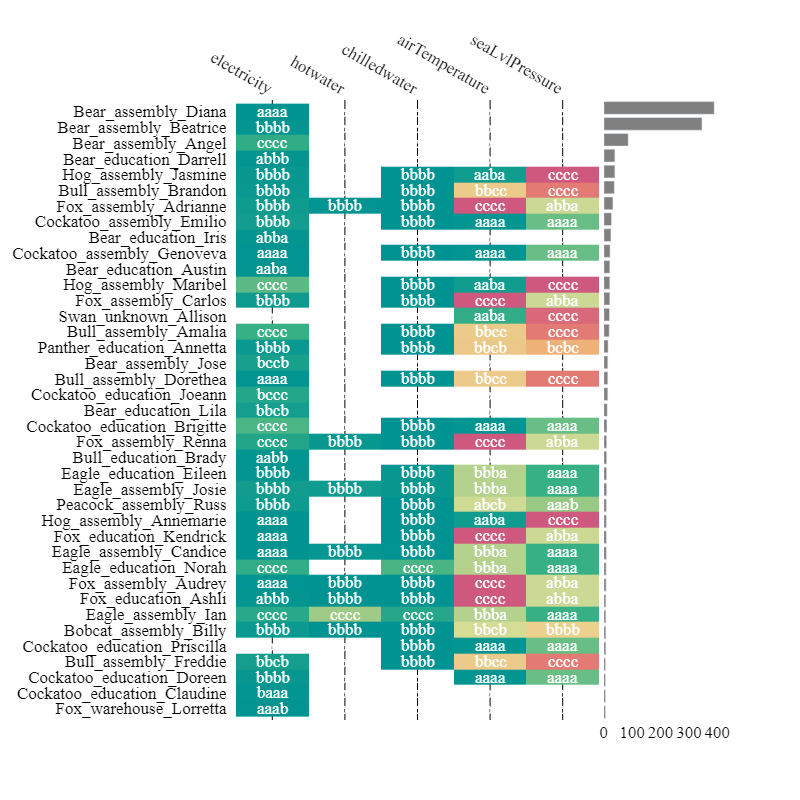

In [6]:
# Heatmap with count plot
fig = ut.SAXannotated_hm_wcounts(df_olap_normalized, df_text_group_filter)
ut.png_output([800,800])
fig.show()
fig.write_image(path_fig_out+"cross_blgattrib_SAX_timeslice_"+timestamp+"_reducedwcounts_"+version+".png", width=800, height=800)

# Mining
## Cross building clustering from multi-attribute
Buildings are clustered together from a within time slice view of the data cube. Here multi-attributes are used with clustering leveraging high-dimensional similarity metrics, namely from weigthed averaged multi-attribute daily series.

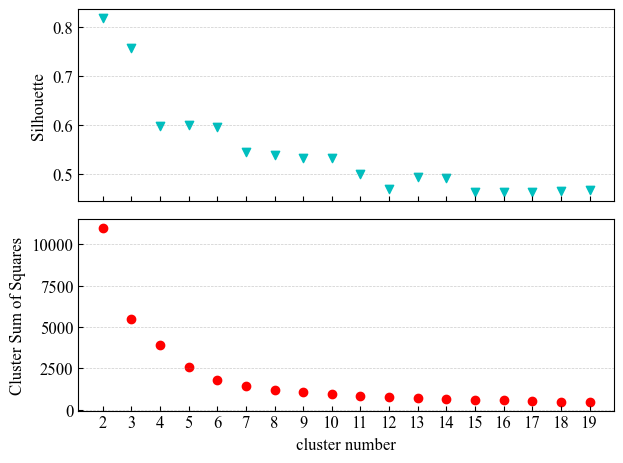

In [7]:
# Scale per attribute across buildings
df_scaled = df.copy()
scaler_function = StandardScaler()
for col in columns_considered:
    df_scaled[col] = ut.scale_NanRobust(df_scaled[col].values, scaler=scaler_function)
df_scaled = ut.multicol_inverseCols(df_scaled)


# Weighted average of attribute time series
def weighted_average(df_in, dict_weights):
    df = df_in.copy()
    # Drop columns full of NaNs
    df.dropna(axis=1, how='all', inplace=True)
    # Identifying remaining columns
    columns_left = df.columns.values.tolist()
    # Creating weight vector from remaining columns
    weights_left = [dict_weights[key] for key in dict_weights.keys() if key in columns_left]
    # Adjusting weights should their total be different from 1
    total_w = sum(weights_left)
    if 1-total_w != 0:
        weights_left = [w * 1/total_w for w in weights_left]
    return np.average(df, weights=weights_left, axis=1)

# Define weight vector
col_key = ['electricity', 'hotwater', 'chilledwater', 'airTemperature', 'seaLvlPressure']
weights = [0.7, 0.1, 0.1, 0.05, 0.05]
dict_weights = {col_key[i]: weights[i] for i in range(len(col_key))} 

# Identify flat list of all retained buildings
flatList_allBuildings = [ item for elem in df_text_group_filter.all_buildings.values for item in elem]

# Apply averaging per retained building
df_clust = pd.DataFrame(columns=flatList_allBuildings)
for blg in flatList_allBuildings:
    df_clust[blg] = weighted_average(df_scaled[blg], dict_weights)

# Drop columns with more than 60% NaNs
df_clust = df_clust.loc[:, df_clust.isna().mean() < .6]
# Set index
df_clust.index = df_scaled.index
# Interpolate gaps in weather data
df_clust = df_clust.interpolate(method='time', limit_direction='both')

# Identify optimal cluster number
wcss, sil = ut.elbow_method(df_clust.transpose(), n_cluster_max=20)
# Plot
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = ['Times New Roman']
version = "v1.0.1"
fig = ut.similarity_index_plot(wcss, sil)
fig.savefig(path_fig_out+"CrossBlgAttrib_"+timestamp+"_cluster_SimilarityIndex_"+version+".jpg", dpi=300, bbox_inches='tight')

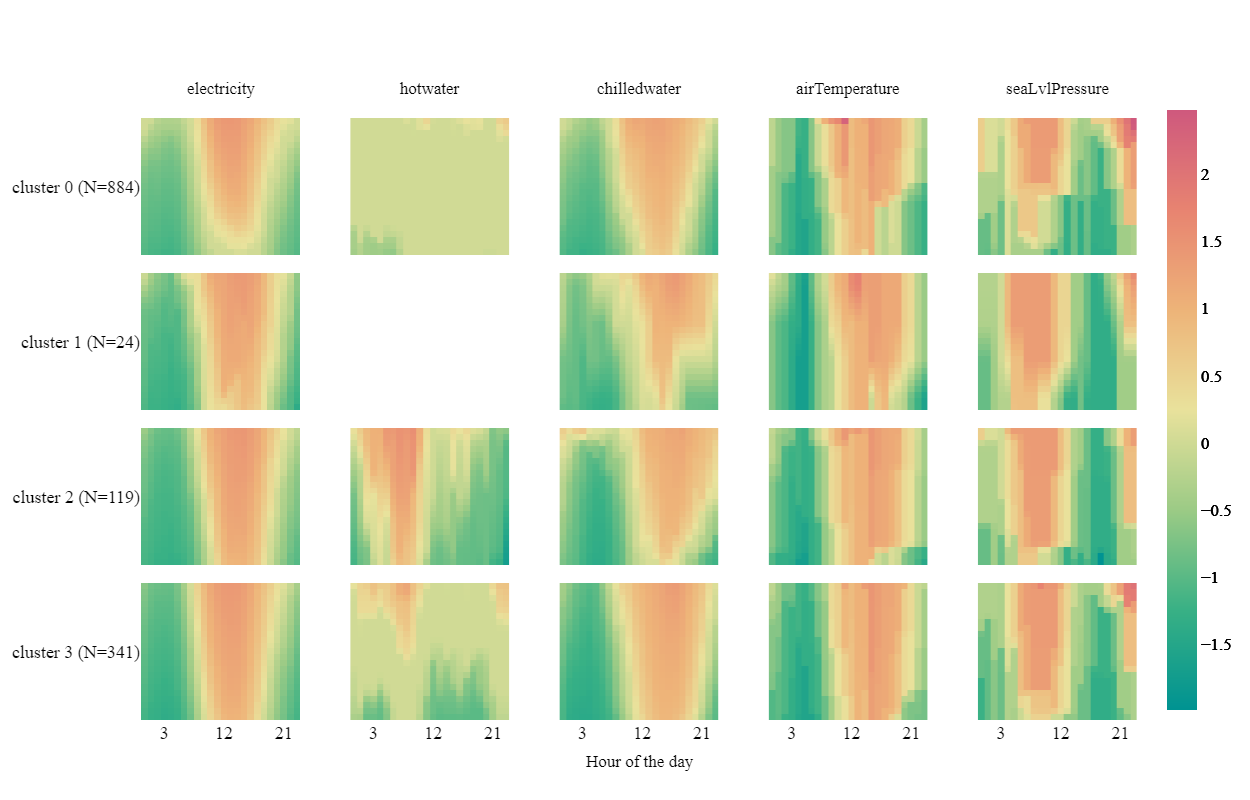

In [8]:
# Cluster the identified motifs
nb_clusters_opt = 4
kmeans = KMeans(n_clusters=nb_clusters_opt, init='k-means++', max_iter=1600, n_init=10, random_state=0)
kmeans_pred_y = kmeans.fit_predict(df_clust.transpose())

# Identify buildings per cluster
blg_clus = dict()
for clus in range(nb_clusters_opt):
    # Identifying buildings within the cluster
    blg_clus[clus] = df_clust.transpose()[kmeans_pred_y == clus].index.values

# Reformating cluster results for plotting
df_data = df.copy()
df_data = ut.multicol_inverseCols(df_data)
clust_dict_data, index_map_dictionary = dict(), dict()
for meter in columns_considered:
    clust_dict_data[meter], index_map_dictionary[meter] = ut.clust_df_reformat(df_data, blg_clus, meter, s_size=10)

# Plotting cluster results results
fig = ut.multiclust_dailyhm_visualization(clust_dict_data, index_map_dictionary)
ut.png_output([len(clust_dict_data.keys())*250, 800])
fig.show()
fig.write_image(path_fig_out+"cross_blgattrib_clust_timeslice_"+timestamp+"_"+version+".png")